In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import keras
from keras.models import Sequential, Model
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
#from keras.applications import VGG19,Resnet
from tensorflow.keras.applications import VGG19
pre_trained_model = tf.keras.applications.VGG19(input_shape=(224,224,3), include_top=False, weights="imagenet")
import cv2
import os
import random
import tensorflow as tf

80150528/80134624 [==============================] - 0s 0us/step


# Loading the Dataset

In [ ]:
labels = ['dandelion', 'daisy','tulip','sunflower','rose']
img_size = 224
def get_data(data_dir):
    data = []
    for label in labels:
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_COLOR)
                resized_arr = cv2.resize(img_arr, (img_size, img_size)) # Reshaping images to preferred size
                data.append([resized_arr, class_num])
            except Exception as e:
                print(e)
    return np.array(data)

In [ ]:
data = get_data("/kaggle/input/flowers-recognition/flowers")

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  from ipykernel import kernelapp as app


# Data Visualization and Preprocessing

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:ylabel='count'>

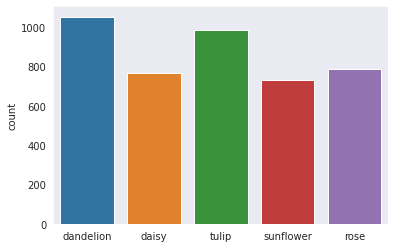

In [ ]:
l = []
for i in data:
    l.append(labels[i[1]])
sns.set_style('dark')
sns.countplot(l)

**The dataset seems balanced as for each training label , enough training examples exist**

**Randomly Previewing first 10 images**

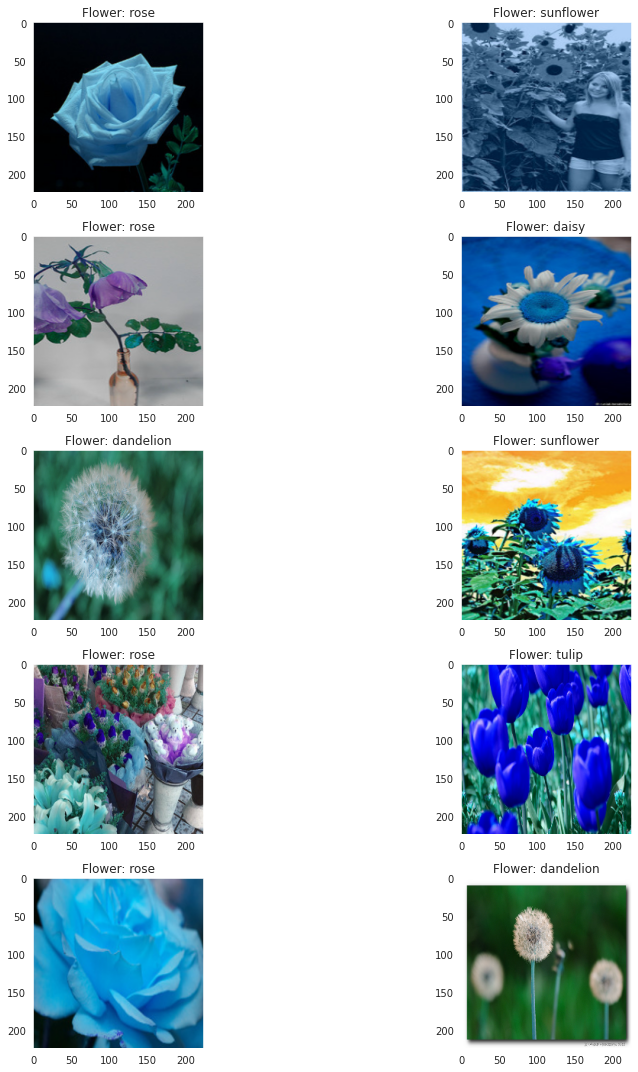

In [ ]:
fig,ax=plt.subplots(5,2)
fig.set_size_inches(15,15)
for i in range(5):
    for j in range (2):
        l=random.randint(0,len(data))
        ax[i,j].imshow(data[l][0])
        ax[i,j].set_title('Flower: '+labels[data[l][1]])

plt.tight_layout()

In [ ]:
x = []
y = []

for feature, label in data:
    x.append(feature)
    y.append(label)

**We perform a grayscale normalization to reduce the effect of illumination's differences.Moreover the CNN converges faster on [0..1] data than on [0..255].**

In [ ]:
# Normalize the data
x = np.array(x) / 255

In [ ]:
# Reshaping the data from 1-D to 3-D as required through input by CNN's
x = x.reshape(-1, img_size, img_size, 3)
y = np.array(y)

In [ ]:
from sklearn.preprocessing import LabelBinarizer
label_binarizer = LabelBinarizer()
y = label_binarizer.fit_transform(y)

In [ ]:
x_train,x_test,y_train,y_test = train_test_split(x , y , test_size = 0.2 , stratify = y , random_state = 0)

In [ ]:
del x,y,data

In [ ]:
# Detect hardware, return appropriate distribution strategy
try:
    # TPU detection. No parameters necessary if TPU_NAME environment variable is
    # set: this is always the case on Kaggle.
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    # Default distribution strategy in Tensorflow. Works on CPU and single GPU.
    strategy = tf.distribute.get_strategy()

print("REPLICAS: ", strategy.num_replicas_in_sync)

REPLICAS:  1


# Training The Model

In [ ]:
with strategy.scope():
    pre_trained_model = VGG19(input_shape=(224,224,3), include_top=False, weights="imagenet")

    for layer in pre_trained_model.layers[:19]:
        layer.trainable = False

    model = Sequential([
        pre_trained_model,
        MaxPool2D((2,2) , strides = 2),
        Flatten(),
        Dense(5 , activation='softmax')])
    model.compile(optimizer = "adam" , loss = 'categorical_crossentropy' , metrics = ['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Functional)           (None, 7, 7, 512)         20024384  
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 3, 3, 512)         0         
_________________________________________________________________
flatten (Flatten)            (None, 4608)              0         
_________________________________________________________________
dense (Dense)                (None, 5)                 23045     
Total params: 20,047,429
Trainable params: 4,742,661
Non-trainable params: 15,304,768
_________________________________________________________________


In [ ]:
from keras.callbacks import ReduceLROnPlateau
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1,factor=0.3, min_lr=0.000001)

In [ ]:
history = model.fit(x_train,y_train, batch_size = 64 , epochs = 12 , validation_data = (x_test, y_test),callbacks = [learning_rate_reduction])

Epoch 1/12
54/54 [==============================] - 56s 680ms/step - loss: 1.0324 - accuracy: 0.6287 - val_loss: 0.7089 - val_accuracy: 0.7546
Epoch 2/12
54/54 [==============================] - 20s 371ms/step - loss: 0.4500 - accuracy: 0.8303 - val_loss: 0.4712 - val_accuracy: 0.8299
Epoch 3/12
54/54 [==============================] - 20s 373ms/step - loss: 0.2773 - accuracy: 0.8957 - val_loss: 0.4564 - val_accuracy: 0.8310
Epoch 4/12
54/54 [==============================] - 20s 376ms/step - loss: 0.1880 - accuracy: 0.9314 - val_loss: 0.4478 - val_accuracy: 0.8611
Epoch 5/12
54/54 [==============================] - 20s 377ms/step - loss: 0.1022 - accuracy: 0.9641 - val_loss: 0.4583 - val_accuracy: 0.8669
Epoch 6/12
54/54 [==============================] - 20s 377ms/step - loss: 0.0804 - accuracy: 0.9748 - val_loss: 0.5770 - val_accuracy: 0.8495
Epoch 7/12
54/54 [==============================] - 20s 378ms/step - loss: 0.0541 - accuracy: 0.9861 - val_loss: 0.5458 - val_accuracy: 0.8553

In [ ]:
print("Loss of the model is - " , model.evaluate(x_test,y_test)[0])
print("Accuracy of the model is - " , model.evaluate(x_test,y_test)[1]*100 , "%")

27/27 [==============================] - 4s 142ms/step - loss: 0.5539 - accuracy: 0.8681
Loss of the model is -  0.5539412498474121
27/27 [==============================] - 4s 142ms/step - loss: 0.5539 - accuracy: 0.8681
Accuracy of the model is -  86.80555820465088 %


# Analysis after Model Training

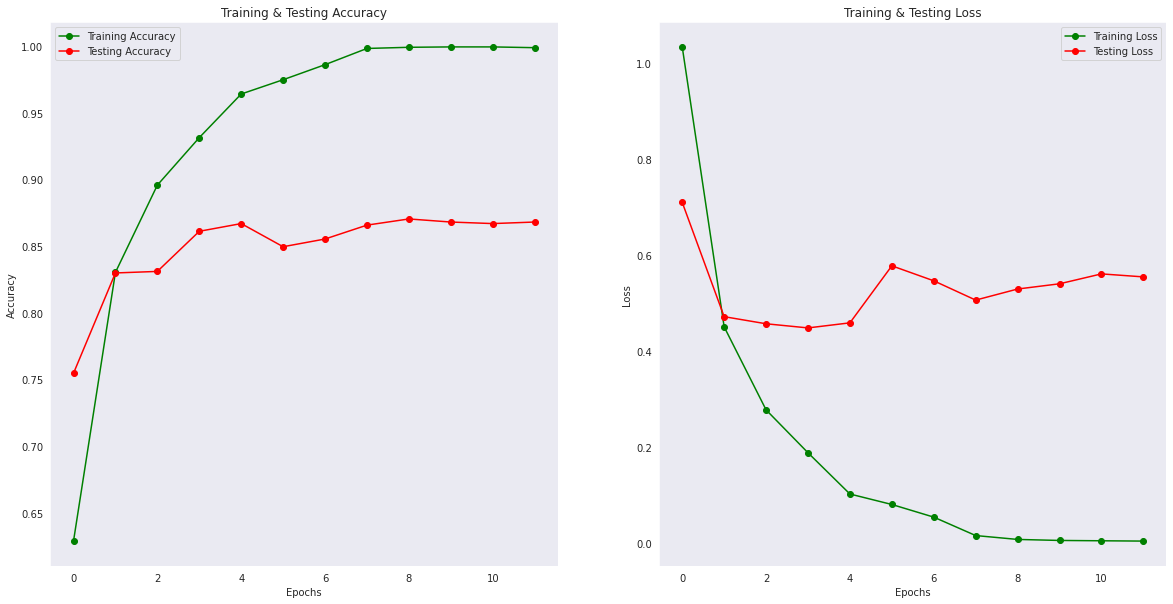

In [ ]:
epochs = [i for i in range(12)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
fig.set_size_inches(20,10)

ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'ro-' , label = 'Testing Accuracy')
ax[0].set_title('Training & Testing Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss , 'g-o' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'r-o' , label = 'Testing Loss')
ax[1].set_title('Training & Testing Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Loss")
plt.show()

In [ ]:
#predictions = model.predict_classes(x_test)
predictions = np.argmax(model.predict(x_test), axis=-1)
predictions[:5]

array([2, 4, 0, 1, 2])

In [ ]:
y_test_inv = label_binarizer.inverse_transform(y_test)

In [ ]:
print(classification_report(y_test_inv, predictions, target_names = labels))

              precision    recall  f1-score   support

   dandelion       0.91      0.92      0.92       210
       daisy       0.89      0.89      0.89       153
       tulip       0.84      0.82      0.83       197
   sunflower       0.87      0.90      0.89       147
        rose       0.81      0.81      0.81       157

    accuracy                           0.87       864
   macro avg       0.87      0.87      0.87       864
weighted avg       0.87      0.87      0.87       864



In [ ]:
cm = confusion_matrix(y_test_inv,predictions)
cm

array([[194,   4,   2,   6,   4],
       [  6, 136,   7,   1,   3],
       [  4,   4, 161,   8,  20],
       [  4,   5,   3, 132,   3],
       [  5,   3,  18,   4, 127]])

In [ ]:
cm = pd.DataFrame(cm , index = labels , columns = labels)

<AxesSubplot:>

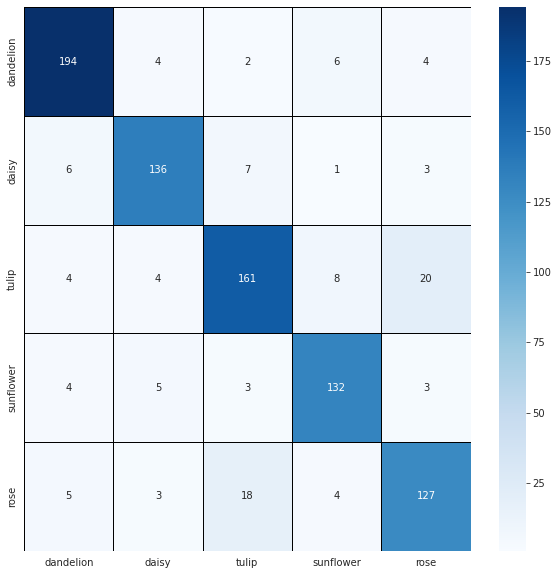

In [ ]:
plt.figure(figsize = (10,10))
sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='' , xticklabels = labels , yticklabels = labels)

In [ ]:
# now storing some properly as well as misclassified indexes'.
i=0
prop_class=[]
mis_class=[]

for i in range(len(y_test_inv)):
    if(y_test_inv[i] == predictions[i]):
        prop_class.append(i)
    if(len(prop_class)==8):
        break

i=0
for i in range(len(y_test_inv)):
    if(y_test_inv[i] != predictions[i]):
        mis_class.append(i)
    if(len(mis_class)==8):
        break

**CORRECTLY CLASSIFIED FLOWER IMAGES**

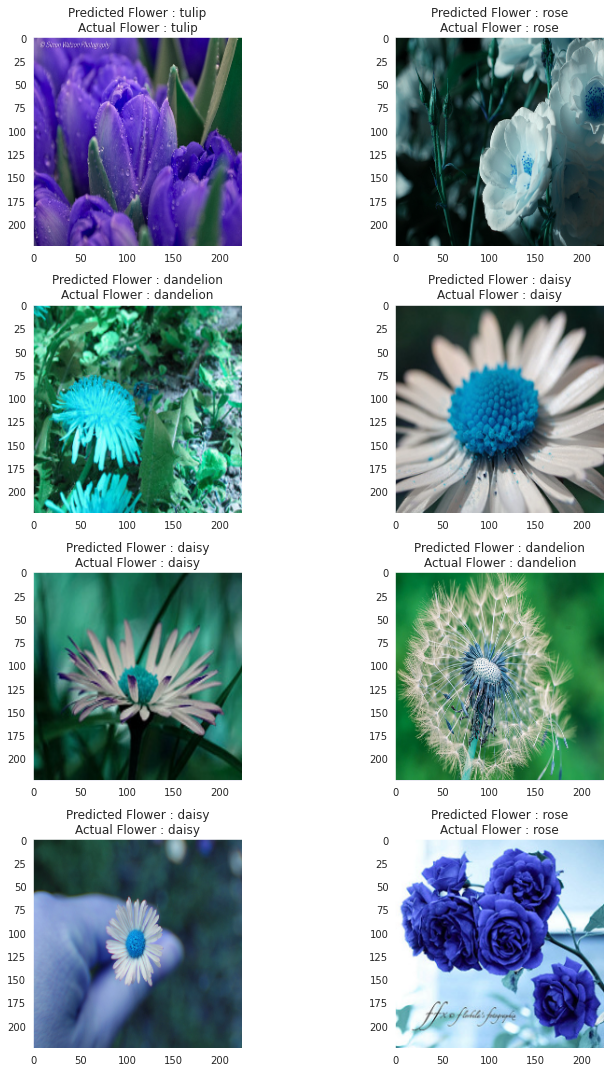

In [ ]:
count=0
fig,ax=plt.subplots(4,2)
fig.set_size_inches(15,15)
for i in range (4):
    for j in range (2):
        ax[i,j].imshow(x_test[prop_class[count]])
        ax[i,j].set_title("Predicted Flower : "+ labels[predictions[prop_class[count]]] +"\n"+"Actual Flower : "+ labels[y_test_inv[prop_class[count]]])
        plt.tight_layout()
        count+=1

**INCORRECTLY CLASSIFIED FLOWER IMAGES**

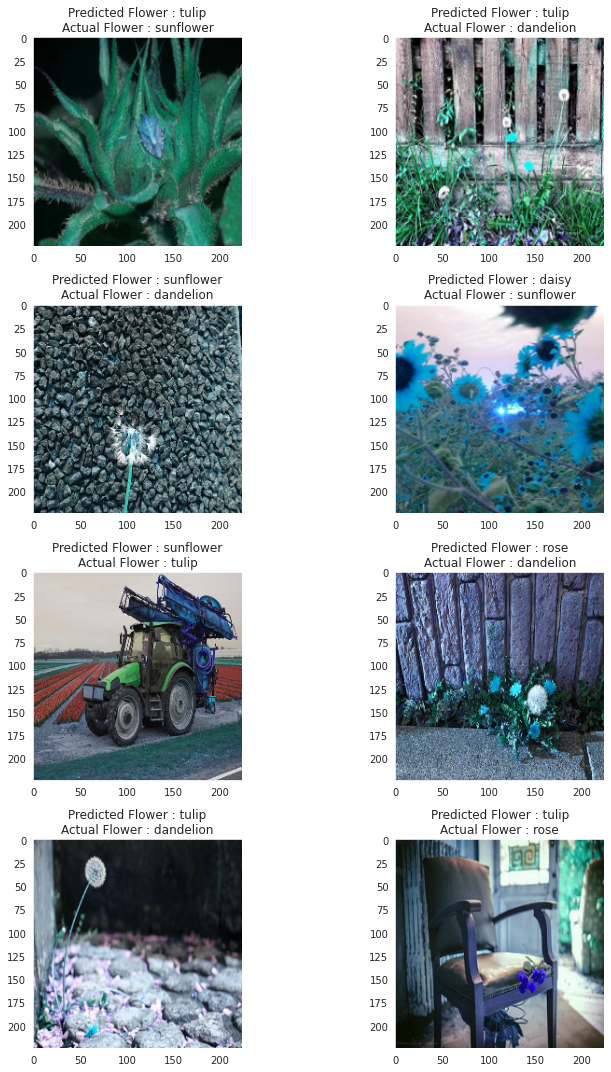

In [ ]:
count=0
fig,ax=plt.subplots(4,2)
fig.set_size_inches(15,15)
for i in range (4):
    for j in range (2):
        ax[i,j].imshow(x_test[mis_class[count]])
        ax[i,j].set_title("Predicted Flower : "+labels[predictions[mis_class[count]]]+"\n"+"Actual Flower : "+labels[y_test_inv[mis_class[count]]])
        plt.tight_layout()
        count+=1